In [15]:
import matplotlib
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import matplotlib.pyplot as plt
import warnings



#Twitter API
consumer_key = 'laygzn9V6hfNvFfQQlwUYpCqj'
consumer_secret = '3cxpPECm2ESRw42noOYz2fxZzpm7en1JQnb69LiiNkvIkjQJU7'
access_token = '595917592-RgspfzTO5KNUFYTq720etSAowArdUCQPK2CmpYtP'
access_secret = 'Q3nLCjHKzmvAOhbPFilcXUgoi6MK1FjYBQExa8Tde4p94'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,retry_count=1,retry_errors=[88], wait_on_rate_limit=True)

In [16]:
df_twitter_archive= pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [17]:
df_twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [18]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
df_image_pred = pd.read_csv('image_predictions.tsv', sep='\t')

In [20]:
df_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [21]:
df_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [22]:
df_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
#Using provided tweet_json.txt file instead of using twitter API
#df_api  = pd.read_json('tweet-json.txt',lines=True)

In [23]:
#List of tweet ids
tweet_ids = df_twitter_archive['tweet_id']

In [10]:
# List of tweets
df_tweets = []


# Need to loop through each tweet id in list from file 1 & write to file
for tweet_id in tweet_ids:
    try:
        tweet = api.get_status(tweet_id, tweet_mode= 'extended')._json 
        
        favorites = tweet['favorite_count'] # number of favorites for the tweet
        retweets = tweet['retweet_count'] # number of retweets
        user_followers = tweet['user']['followers_count'] # number of followers of the user who tweeted
        user_favourites = tweet['user']['favourites_count'] # number of favourites for the user who tweeted
        date_time = tweet['created_at'] # the timestamp i.e. date and time of creation of the tweet
        
        df_tweets.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        


888202515573088257 _ 404 Not Found
144 - No status found with that ID.
873697596434513921 _ 404 Not Found
144 - No status found with that ID.
872668790621863937 _ 404 Not Found
144 - No status found with that ID.
872261713294495745 _ 404 Not Found
144 - No status found with that ID.
869988702071779329 _ 404 Not Found
144 - No status found with that ID.
866816280283807744 _ 404 Not Found
144 - No status found with that ID.
861769973181624320 _ 404 Not Found
144 - No status found with that ID.
856602993587888130 _ 404 Not Found
144 - No status found with that ID.
856330835276025856 _ 404 Not Found
34 - Sorry, that page does not exist.
851953902622658560 _ 404 Not Found
144 - No status found with that ID.
845459076796616705 _ 404 Not Found
144 - No status found with that ID.
844704788403113984 _ 404 Not Found
144 - No status found with that ID.
842892208864923648 _ 404 Not Found
144 - No status found with that ID.
837366284874571778 _ 404 Not Found
144 - No status found with that ID.
8370

Rate limit reached. Sleeping for: 699


754011816964026368 _ 404 Not Found
144 - No status found with that ID.
680055455951884288 _ 404 Not Found
144 - No status found with that ID.


Rate limit reached. Sleeping for: 685


In [11]:
#print(len(df_api))
#df_api.head()
#2354 total rows

NameError: name 'df_api' is not defined

In [25]:
#change  back from df_api 
df_tweets = pd.DataFrame(df_tweets, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])

In [26]:
# save dataFrame to file
df_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)
#print(len(df_api))

In [27]:
#Read tweet_json.txt file to dataframe
#df_api = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

#print(df_api.tweet_id!='NaN')

NameError: name 'df_api' is not defined

In [28]:
df_tweets.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,34406,7151,9086756,145860,2017-08-01 16:23:56+00:00
1,892177421306343426,29837,5378,9086756,145860,2017-08-01 00:17:27+00:00
2,891815181378084864,22452,3544,9086756,145860,2017-07-31 00:18:03+00:00
3,891689557279858688,37617,7362,9086756,145860,2017-07-30 15:58:51+00:00
4,891327558926688256,35924,7906,9086756,145860,2017-07-29 16:00:24+00:00


In [29]:
df_tweets.tail()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
2323,666049248165822465,91,37,9086777,145860,2015-11-16 00:24:50+00:00
2324,666044226329800704,252,117,9086777,145860,2015-11-16 00:04:52+00:00
2325,666033412701032449,102,36,9086777,145860,2015-11-15 23:21:54+00:00
2326,666029285002620928,115,39,9086777,145860,2015-11-15 23:05:30+00:00
2327,666020888022790149,2315,435,9086777,145860,2015-11-15 22:32:08+00:00


In [30]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweet_id         2328 non-null   int64              
 1   favorites        2328 non-null   int64              
 2   retweets         2328 non-null   int64              
 3   user_followers   2328 non-null   int64              
 4   user_favourites  2328 non-null   int64              
 5   date_time        2328 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(5)
memory usage: 109.2 KB


In [32]:
print(len(df_tweets))

2328


In [33]:
df_twitter_archive.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1243,711968124745228288,NaN,NaN,2016-03-21 17:30:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's trapped in a cup of coffee....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711968124...,10,10,Winston,None,None,pupper,None
2071,671115716440031232,NaN,NaN,2015-11-29 23:57:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Phred. He isn't steering, looking at the ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/671115716...,6,10,Phred,None,None,None,None
1493,692752401762250755,NaN,NaN,2016-01-28 16:53:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Hello yes could I get one pupper to go please...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/692752401...,13,10,None,None,None,pupper,None
1303,707420581654872064,NaN,NaN,2016-03-09 04:19:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Keurig. He's a rare dog. Laughs like a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707420581...,4,10,Keurig,None,None,None,None
1772,678278586130948096,NaN,NaN,2015-12-19 18:19:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Another spooky pupper here. Most definitely fl...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678278586...,10,10,None,None,None,pupper,None
968,750147208377409536,NaN,NaN,2016-07-05 02:00:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","And finally, happy 4th of July from the squad ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/750147208...,13,10,None,None,None,None,None
411,823269594223824897,NaN,NaN,2017-01-22 20:42:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. Please don't...,8.222448e+17,4.196984e+09,2017-01-20 00:50:15 +0000,https://twitter.com/dog_rates/status/822244816...,11,10,None,None,None,None,None
2216,668537837512433665,NaN,NaN,2015-11-22 21:13:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Spark. He's nervous. Other dog hasn't ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668537837...,8,10,Spark,None,None,None,None
635,793601777308463104,NaN,NaN,2016-11-01 23:53:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dobby. I can't stop looking at her fee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793601777...,12,10,Dobby,None,None,None,None
698,786363235746385920,NaN,NaN,2016-10-13 00:29:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rizzo. He has many talents. A true ren...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/786363235...,13,10,Rizzo,doggo,None,None,None


In [34]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [36]:
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_pred_clean = df_image_pred.copy()
df_api_clean = df_tweets.copy()

**Issue 1: (tidiness) Master dataset where all pieces of gathered data is created**

In [37]:
df_twitter_archive_clean = pd.merge(left=df_twitter_archive_clean,
                                 right=df_api_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [38]:
df_twitter_archive_clean = df_twitter_archive_clean.merge(df_image_pred_clean, on='tweet_id', how='inner')

In [42]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2057
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2058 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2058 non-null   object             
 4   source                      2058 non-null   object             
 5   text                        2058 non-null   object             
 6   retweeted_status_id         72 non-null     float64            
 7   retweeted_status_user_id    72 non-null     float64            
 8   retweeted_status_timestamp  72 non-null     object             
 9   expanded_urls               2058 non-null   object             
 10  rating_numerator            2058 non-null   int64           

In [45]:
df_twitter_archive_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [47]:
#print (df_twitter_archive_clean['life_stage'].value_counts())

KeyError: 'life_stage'

**Issue 2 (tidiness): Combine 4 columns (doggo, floofer, pupper, puppo) into 1 column (life_stage)**

In [48]:
melt_coumns = ['doggo', 'floofer', 'pupper', 'puppo']
stay_columns = [x for x in df_twitter_archive_clean.columns.tolist() if x not in melt_coumns]

# Melt the the columns into values
df_twitter_archive_clean = pd.melt(df_twitter_archive_clean, id_vars = stay_columns, value_vars = melt_coumns, 
                         var_name = 'stages', value_name = 'life_stage')

In [63]:
#Test
print(df_twitter_archive_clean['life_stage'].value_counts())

None       1402
pupper      173
doggo        53
puppo        22
floofer       8
Name: life_stage, dtype: int64


In [64]:
df_twitter_archive_clean.life_stage.value_counts()

None       1402
pupper      173
doggo        53
puppo        22
floofer       8
Name: life_stage, dtype: int64

**Issue 3: Dog names missing filled with incorrect names. None should be converted to NaN** <br>
Note there are also addtional invalid names which include a, an & the for example

In [65]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'None'].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages,life_stage,breed


In [53]:
#Replace None with Nan
df_twitter_archive_clean.name = df_twitter_archive_clean.name.replace('None', np.nan)

**Issue 4: Remove predictions which are not dogs**

In [54]:
not_dogs = df_twitter_archive_clean.query('p1_dog == False and p2_dog == False and p3_dog == False')
dogs = df_twitter_archive_clean.index.difference(not_dogs.index)
print('All      = ',df_twitter_archive_clean.shape)
print('Not Dogs = ',not_dogs.shape)
print('Dogs     = ',dogs.shape)

df_twitter_archive_clean = df_twitter_archive_clean.loc[dogs].copy()

All      =  (8232, 31)
Not Dogs =  (1288, 31)
Dogs     =  (6944,)


**Issue 5: Clean source values in twitter archive**

In [55]:
df_twitter_archive_clean['source'] = df_twitter_archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [56]:
df_twitter_archive_clean['source'].value_counts()

Twitter for iPhone    6820
Twitter Web Client      92
TweetDeck               32
Name: source, dtype: int64

**Issue 6: Replace underscore from dognames p1, p2, p3**

In [57]:
for i in ('p1','p2','p3'):
    df_twitter_archive_clean[str(i)]=df_twitter_archive_clean[str(i)].str.replace("_", ' ')
    df_twitter_archive_clean[str(i)]=df_twitter_archive_clean[str(i)].str.capitalize()

In [58]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages,life_stage
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,doggo,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,doggo,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador retriever,0.168086,True,Spatula,0.040836,False,doggo,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,doggo,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.425595,True,Irish terrier,0.116317,True,Indian elephant,0.076902,False,doggo,None


**Issue 7: Delete duplicates from all dataframes**

In [59]:
# Delete the retweets
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean.retweeted_status_id)]
# Delete tweet_id duplicates
df_twitter_archive_clean = df_twitter_archive_clean.drop_duplicates()
#Delete dog_stage duplicates
df_twitter_archive_clean = df_twitter_archive_clean.sort_values('life_stage').drop_duplicates('tweet_id', keep = 'last')

**Issue 8: Remove retweets & replies (where in_reply_to_status_id & retweeted_status_id = NaN)** <br>


In [60]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.in_reply_to_status_id.isnull()]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

In [66]:
print(df_twitter_archive_clean['life_stage'].value_counts())

None       1402
pupper      173
doggo        53
puppo        22
floofer       8
Name: life_stage, dtype: int64


**Issue 9: No information on dog breed in tweets**

In [72]:
#Create breed field for the highest dog breed prediction

#Copy
df_predictions_tmp = df_image_pred.copy()

# New breed column
df_predictions_tmp['breed'] = np.where(df_predictions_tmp['p1_dog'], df_predictions_tmp['p1'],
                              np.where(df_predictions_tmp['p2_dog'], df_predictions_tmp['p2'],
                              np.where(df_predictions_tmp['p3_dog'], df_predictions_tmp['p3'],
                              np.NaN
                              )))


df_predictions_tmp = df_predictions_tmp[['tweet_id', 'breed']]


# Merge master dataframe with new breed column 
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_predictions_tmp, on='tweet_id', how='left')

In [73]:
df_twitter_archive_clean['breed'].value_counts().head()

golden_retriever      156
Labrador_retriever    103
Pembroke               94
Chihuahua              90
pug                    62
Name: breed, dtype: int64

In [74]:
print(df_twitter_archive_clean['life_stage'].value_counts())

None       1402
pupper      173
doggo        53
puppo        22
floofer       8
Name: life_stage, dtype: int64


**Issue 10: Remove unused columns in master file**

In [75]:
#We have 1 breed column (for highest prediction) now so we can remove orignal predictions columns as they are no longer needed
df_twitter_archive_clean = df_twitter_archive_clean.drop('p1',1)
df_twitter_archive_clean = df_twitter_archive_clean.drop('p2',1)
df_twitter_archive_clean = df_twitter_archive_clean.drop('p3',1)


In [86]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658 entries, 0 to 1657
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1658 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1658 non-null   object 
 4   source                      1658 non-null   object 
 5   text                        1658 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      float64
 9   expanded_urls               1658 non-null   object 
 10  rating_numerator            1658 non-null   int64  
 11  rating_denominator          1658 non-null   int64  
 12  name                        1259 non-null   object 
 13  favorites                   1658 

**Issue 11: Rating_numerator column should of type float and also it should be correctly extracted**

In [93]:
incorrect_ratings = df_twitter_archive_clean[df_twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id','text', 'rating_numerator','rating_denominator']]

print (incorrect_ratings)

                tweet_id                                               text  \
149   883482846933004288  This is Bella. She hopes her smile made you sm...   
761   680494726643068929  Here we have uncovered an entire battalion of ...   
864   786709082849828864  This is Logan, the Chow who lived. He solemnly...   
1474  778027034220126208  This is Sophie. She's a Jubilant Bush Pupper. ...   

      rating_numerator  rating_denominator  
149                  5                  10  
761                 26                  10  
864                 75                  10  
1474                27                  10  


C:\Users\shane\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [102]:
# Set correct numerators for incorrect ratings
df_twitter_archive_clean.loc[(df_twitter_archive_clean['tweet_id'] == 883482846933004288) & (df_twitter_archive_clean['rating_numerator'] == 5), ['rating_numerator']] = 13.5
df_twitter_archive_clean.loc[(df_twitter_archive_clean['tweet_id'] == 786709082849828864) & (df_twitter_archive_clean['rating_numerator'] == 75), ['rating_numerator']] = 9.75
df_twitter_archive_clean.loc[(df_twitter_archive_clean['tweet_id'] == 778027034220126208) & (df_twitter_archive_clean['rating_numerator'] == 27), ['rating_numerator']] = 11.27
df_twitter_archive_clean.loc[(df_twitter_archive_clean['tweet_id'] == 680494726643068929) & (df_twitter_archive_clean['rating_numerator'] == 26), ['rating_numerator']] = 11.26

In [104]:
# Convert to correct data types
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].astype(float)
df_twitter_archive_clean['rating_denominator'] = df_twitter_archive_clean['rating_denominator'].astype(int)

In [108]:
#Test
ratings_test = df_twitter_archive_clean[df_twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id','text', 'rating_numerator','rating_denominator']]

print (ratings_test)

                tweet_id                                               text  \
149   883482846933004288  This is Bella. She hopes her smile made you sm...   
761   680494726643068929  Here we have uncovered an entire battalion of ...   
864   786709082849828864  This is Logan, the Chow who lived. He solemnly...   
1474  778027034220126208  This is Sophie. She's a Jubilant Bush Pupper. ...   

      rating_numerator  rating_denominator  
149              13.50                  10  
761              11.26                  10  
864               9.75                  10  
1474             11.27                  10  


C:\Users\shane\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


# Save clean DataFrame to csv file

In [112]:
df_twitter_archive_clean.drop(df_twitter_archive_clean.columns[df_twitter_archive_clean.columns.str.contains('Unnamed',case = False)],axis = 1)
df_twitter_archive_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [113]:
df_twitter_archive_clean = pd.read_csv('twitter_archive_master.csv')
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658 entries, 0 to 1657
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1658 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1658 non-null   object 
 4   source                      1658 non-null   object 
 5   text                        1658 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      float64
 9   expanded_urls               1658 non-null   object 
 10  rating_numerator            1658 non-null   float64
 11  rating_denominator          1658 non-null   int64  
 12  name                        1259 non-null   object 
 13  favorites                   1658 

# Visualisations

In [78]:
matplotlib.style.use('ggplot')

**1: Graph of top 10 Dog Breeds**

In [79]:
ip_clean = df_image_pred.copy()


df = pd.DataFrame(ip_clean.p1.value_counts())
df = df.reset_index()
df.columns = ['breed', 'counts']
df = df.head(10)


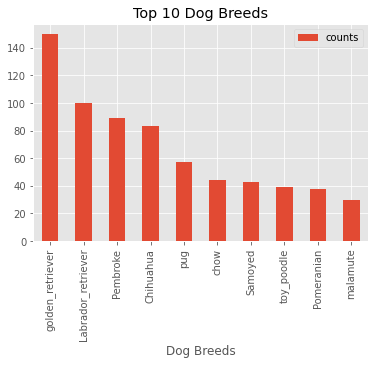

In [80]:
graph = df[['breed','counts']].plot(x='breed',kind='bar')
plt.xlabel('Dog Breeds')
plt.title('Top 10 Dog Breeds')

#Save graph 
fig = graph.get_figure()
fig.savefig('chart1.png')

**2: Scatter plot between favorites and retweets**

Text(0.5, 1.0, 'Retweets and favorites Scatter plot')

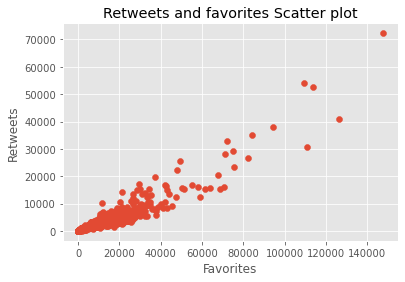

In [81]:
plt.scatter(df_twitter_archive_clean['favorites'], df_twitter_archive_clean['retweets'])
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')

**3: Graph of how users access twitter**

In [82]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    1628
Twitter Web Client      22
TweetDeck                8
Name: source, dtype: int64

In [83]:
df = pd.DataFrame(df_twitter_archive_clean.source.value_counts())
df = df.reset_index()
df.head()
df.columns = ['source', 'counts']

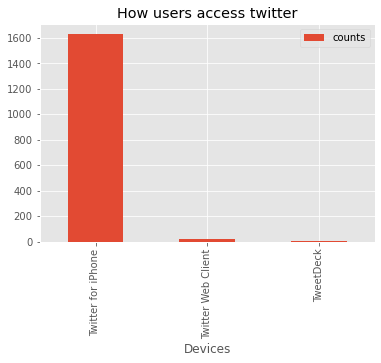

In [111]:
graph = df[['source','counts']].plot(x='source',kind='bar')
plt.xlabel('Devices')
plt.title('How users access twitter')

# Save graph 
fig = graph.get_figure()
fig.savefig('chart6.png')